# Imports

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import glob
import os
import csv
from intensity_normalization.normalize import hm
import pickle

# Basic Helper Functions

In [2]:
def get_rand_slice_list(data_shape):
    x_max, y_max, z_max = data_shape
    x_curr = randint((x_max/2)-(x_max/4), (x_max/2)+(x_max/4))
    y_curr = randint((y_max/2)-(y_max/4), (y_max/2)+(y_max/4))
    z_curr = randint((z_max/2)-(z_max/4), (z_max/2)+(z_max/4))
    return x_curr, y_curr, z_curr



def show_mri_slices_random(mri_data, explicit_pos=None):
    """ Function to display random image slices """
    '''Provision to give exact slice numbers'''
    '''Random numbers biased towards middle'''
    
    print('Data Shape = ',mri_data.shape)
    if explicit_pos==None:
        x_curr, y_curr, z_curr = get_rand_slice_list(mri_data.shape)
    else:
        x_curr, y_curr, z_curr = explicit_pos
    print('Data Positions = ',x_curr, y_curr, z_curr)
    slice_0 = mri_data[x_curr, :, :]
    slice_1 = mri_data[:, y_curr, :]
    slice_2 = mri_data[:, :, z_curr]
    print('Slice 1: value: ',x_curr)
    plt.imshow(slice_0.T, cmap='gray', origin=0)
    plt.show()
    print('Slice 2: value: ',y_curr)
    plt.imshow(slice_1.T, cmap='gray', aspect=0.5, origin=0)
    plt.show()
    print('Slice 3: value: ',z_curr)
    plt.imshow(slice_2.T, cmap='gray', aspect=0.5, origin=0)
    plt.show()
    


# Brain Masking Function

In [3]:
def BrainMasker(brain_obj,skull_obj):
    skull_data = skull_obj.get_fdata()
    brain_data = brain_obj.get_fdata()
    maskedObj = np.ma.masked_array(brain_data,(skull_data+1)%2, fill_value=0)
    h = maskedObj.filled()
    new_obj = nib.Nifti1Image(h, brain_obj.affine)
    return new_obj

# Dataset Loading Functions

In [4]:
def load_MS_dataset_paths(MS_dataset_path):
    actual_data={}
    list_of_set_of_datasets =glob.glob(MS_dataset_path+'/*/')
    whole_list_of_datasets=[]
    for set_of_datasets in list_of_set_of_datasets:
        list_of_datasets = glob.glob(set_of_datasets+'/*/')
        whole_list_of_datasets.extend(list_of_datasets)
    #print((whole_list_of_datasets))
    for curr_data_path in whole_list_of_datasets:
        curr_dataset={}
        curr_dataset['brainmask'] = glob.glob(curr_data_path+'/*brainmask.nii.gz')[-1]
        curr_dataset['segmentation'] = glob.glob(curr_data_path+'/*consensus_gt.nii.gz')[-1]
        curr_dataset['t1w'] = glob.glob(curr_data_path+'/*T1W.nii.gz')[-1]
        curr_dataset['t1w_enhance'] = glob.glob(curr_data_path+'/*T1WKS.nii.gz')[-1]
        curr_dataset['t2w'] = glob.glob(curr_data_path+'/*T2W.nii.gz')[-1]
        curr_dataset['flair'] = glob.glob(curr_data_path+'/*FLAIR.nii.gz')[-1]
        for name,val in curr_dataset.items():
            if val==[]:
                print('Error at',name,': ',curr_data_path)
                return
        dataset_name_parts = curr_data_path.split(os.sep)
        dataset_name_parts.pop()
        dataset_name = dataset_name_parts.pop()
        
        actual_data[dataset_name]=curr_dataset
        
    return actual_data 

def load_dataset_details(MS_dataset_path):
    file=MS_dataset_path + '\patient26-30\patient_info.csv'
    dict_list = []
    with open(file) as fh:
        rd = csv.DictReader(fh, delimiter=',') 
        for row in rd:
            dict_list.append(dict(row))
    return dict_list
        
        
def show_all_data_patient(patient_datapath_dict):
    t1w_obj = nib.load(patient_datapath_dict['t1w'])
    t2w_obj = nib.load(patient_datapath_dict['t2w'])
    flair_obj = nib.load(patient_datapath_dict['flair'])
    skull_obj = nib.load(patient_datapath_dict['brainmask'])
    concensus_obj = nib.load(patient_datapath_dict['segmentation'])
    
    t1w_data = t1w_obj.get_fdata()
    t2w_data = t2w_obj.get_fdata()
    flair_data = flair_obj.get_fdata()
    concensus_data = concensus_obj.get_fdata()
    skull_data = skull_obj.get_fdata()
    
    x,y,z = get_rand_slice_list(t1w_data.shape)
    
    print('t1w')
    show_mri_slices_random(t1w_data,(x,y,z))
    print('t2w')
    show_mri_slices_random(t2w_data,(x,y,z))
    print('flair')
    show_mri_slices_random(flair_data,(x,y,z))
    print('concensus')
    show_mri_slices_random(concensus_data,(x,y,z))
    print('skull data')
    show_mri_slices_random(skull_data,(x,y,z))
    
def printDatasetDetails(all_dataset_paths, dataset_details):
    print('Dataset Paths:')
    for i, val in all_dataset_paths.items():
        print(i,val)
    print('Dataset Details:')
    print('Number: ',len(dataset_details))
    for d in dataset_details:
        print(d)

# Nyul Intensity Normalization Function

#### Code for Nyul's Intensity algorithm taken from package:
https://github.com/jcreinhold/intensity-normalization

### This algorithm uses Piecewise Histogram Matching

In [5]:
class nyul_standardization:
    def __init__(self, train_paths_dict):
        self.standard_scale, self.percs =hm.train(train_paths_dict)
        #print('scale: ',standard_scale,'\npercs: ',percs)
    def normalize(self,img_obj):
        output_obj=hm.do_hist_norm(img_obj,self.percs,self.standard_scale)
        return output_obj
    

# Process PipeLine

1. Dataset Loading
2. Dataset Viewing
3. Image Processing
    a. Skull Stripping
    b. Intensity Normalization
    c. Size Standardization
4. Goal #1
    Getting segmented images using flair mri scans only
    
    
5. Scoring in Segmentation
    Dice Scoring


Dice score = 2*number of true positives  / (2*number of true positives + number of false positives + number of false negatives)

### 1. Dataset Loading

In [6]:
dataset_path = 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS'

In [7]:
all_dataset_paths = load_MS_dataset_paths(dataset_path)
dataset_details = load_dataset_details(dataset_path)
printDatasetDetails(all_dataset_paths,dataset_details)

Dataset Paths:
patient01 {'brainmask': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_brainmask.nii.gz', 'segmentation': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_consensus_gt.nii.gz', 't1w': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_T1W.nii.gz', 't1w_enhance': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_T1WKS.nii.gz', 't2w': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_T2W.nii.gz', 'flair': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient01\\patient01_FLAIR.nii.gz'}
patient02 {'brainmask': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient02\\patient02_brainmask.nii.gz', 'segmentation': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient02\\patient02_consensus_gt.nii.gz', 't1w': 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient02\\patient02_T1W.nii.gz', 't1w_enhance': '

### 2. Show A Patient Data Example (Data Visualization)

t1w
Data Shape =  (192, 512, 512)
Data Positions =  138 320 374
Slice 1: value:  138


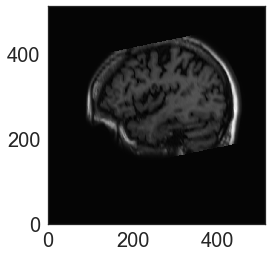

Slice 2: value:  320


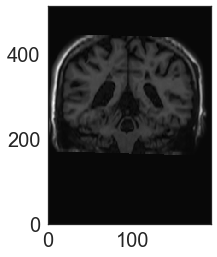

Slice 3: value:  374


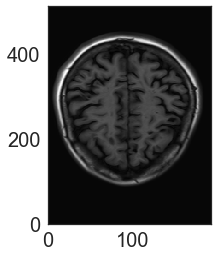

t2w
Data Shape =  (192, 512, 512)
Data Positions =  138 320 374
Slice 1: value:  138


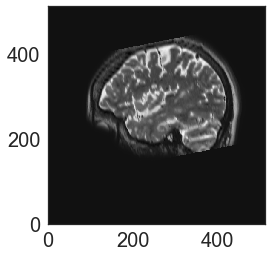

Slice 2: value:  320


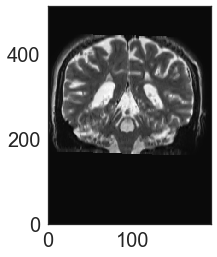

Slice 3: value:  374


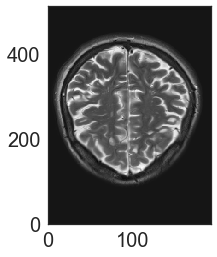

flair
Data Shape =  (192, 512, 512)
Data Positions =  138 320 374
Slice 1: value:  138


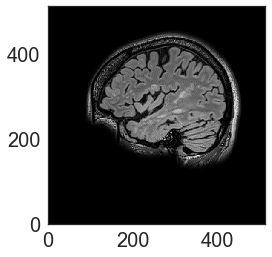

Slice 2: value:  320


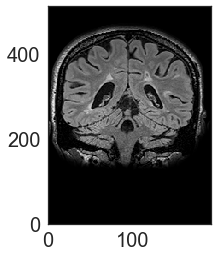

Slice 3: value:  374


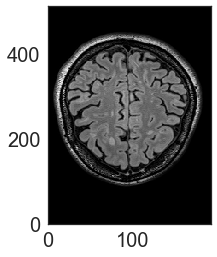

concensus
Data Shape =  (192, 512, 512)
Data Positions =  138 320 374
Slice 1: value:  138


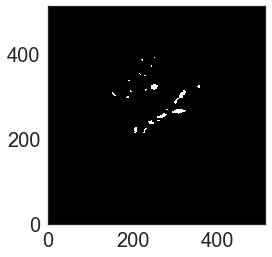

Slice 2: value:  320


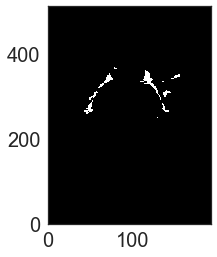

Slice 3: value:  374


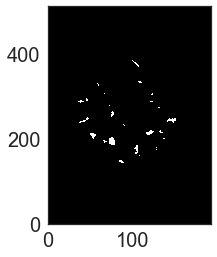

skull data
Data Shape =  (192, 512, 512)
Data Positions =  138 320 374
Slice 1: value:  138


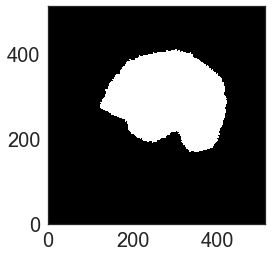

Slice 2: value:  320


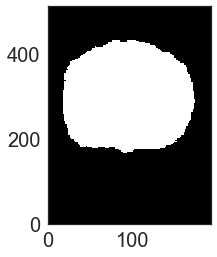

Slice 3: value:  374


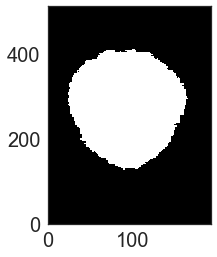

In [8]:
show_all_data_patient(all_dataset_paths['patient01'])

### 3. Data Image Processing Pipeline Function

In [9]:
new_save_path = 'F:\\8thsemProjects\\MRIAnalysis\\PreprocData'

In [10]:
flair_good_dict = {'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient03\\patient03_FLAIR.nii.gz', 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient05\\patient05_FLAIR.nii.gz'}
t1_good_dict = {'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient03\\patient03_T1W.nii.gz', 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient05\\patient05_T1W.nii.gz'}
t2_good_dict = {'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient03\\patient03_T2W.nii.gz', 'F:\\8thsemProjects\\MRIAnalysis\\3dmrMS\\patient01-05\\patient05\\patient05_T2W.nii.gz'}

Building the intensity normalizers

In [11]:
flair_intensity_normalizer = nyul_standardization(flair_good_dict)
t1_intensity_normalizer = nyul_standardization(t1_good_dict)
t2_intensity_normalizer = nyul_standardization(t2_good_dict)

In [12]:
def data_img_proc_pipeln(input_obj,normalizer,skull_obj):
    normalized = normalizer.normalize(input_obj)
    skull_stripped = BrainMasker(normalized,skull_obj)
    return skull_stripped
    

# Actual Execution

In [15]:
def prepoc_pipeline(all_dataset_paths,dataset_details):
    for patient_iter, patient_datapath_dict in all_dataset_paths.items():
        print(patient_iter)
        t1w_obj = nib.load(patient_datapath_dict['t1w'])
        t2w_obj = nib.load(patient_datapath_dict['t2w'])
        flair_obj = nib.load(patient_datapath_dict['flair'])
        skull_obj = nib.load(patient_datapath_dict['brainmask'])
        concensus_obj = nib.load(patient_datapath_dict['segmentation'])
        
        new_curr_dir = new_save_path + '\\' + patient_iter
        
        print('Making :',new_curr_dir)
        os.makedirs(new_curr_dir)
        
        prepoc_t1 = data_img_proc_pipeln(t1w_obj,t1_intensity_normalizer,skull_obj)
        prepoc_t2 = data_img_proc_pipeln(t2w_obj,t2_intensity_normalizer,skull_obj)
        prepoc_flair = data_img_proc_pipeln(flair_obj,flair_intensity_normalizer,skull_obj)
        
        nib.save(prepoc_t1, new_curr_dir+'\\' + patient_iter + '_t1.nii.gz')
        nib.save(prepoc_t2, new_curr_dir+'\\' + patient_iter + '_t2.nii.gz')
        nib.save(prepoc_flair, new_curr_dir+'\\' + patient_iter + '_flair.nii.gz')
        
        nib.save(concensus_obj, new_curr_dir+'\\' + patient_iter + '_label.nii.gz')
        
    print('Saving details')
    with open(new_save_path+'\\data_details.pickle', 'wb') as handle:
        pickle.dump(dataset_details, handle, protocol=pickle.HIGHEST_PROTOCOL)      
    
        

In [16]:
prepoc_pipeline(all_dataset_paths,dataset_details)

patient01
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient01
patient02
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient02
patient03
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient03
patient04
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient04
patient05
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient05
patient06
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient06
patient07
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient07
patient08
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient08
patient09
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient09
patient10
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient10
patient11
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient11
patient12
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient12
patient13
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient13
patient14
Making : F:\8thsemProjects\MRIAnalysis\PreprocData\patient14
patien